# Process Seq Match

# TO DO
- remove practive trials. [x]
- remove subjects who did poorly or did bad version of task

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
import seaborn as sns
import SD_functions as SDF

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def sample_compare(sample,shuf,n_boot=10000):
    this_mu = np.mean(sample)
    n_sam = len(sample)
    assert n_sam>1, 'invalid sample'
    these_shuf_mu = np.zeros(n_boot)
    for n in range(n_boot):
        these_shuf_mu[n] = np.mean(np.random.choice(shuf,n_sam))

    p_val = np.mean(np.abs(these_shuf_mu)>np.abs(this_mu))
    return p_val

In [3]:
def mean_stats(x):
    this_t = scipy.stats.ttest_1samp(x,0)
    print('%.2f \u00B1 %.2f (n=%d) t=%.3f (p=%.4f)' %(np.mean(x),np.std(x),len(x),*this_t))

In [4]:
data_root = '../raw_data/Data_v6/'
fls = !ls {data_root}
len(fls)
pi=np.pi
pm = np.array([-1,1])
r2d,d2r = 180/pi,pi/180

In [5]:
def sav_fig(nam):
    root = './Figures_v1/'
    plt.savefig(root + nam +'.svg',dpi=1200)

import matplotlib
cmap = matplotlib.cm.get_cmap('Dark2')
ct = cmap(np.linspace(0,1,4))

plt.rcParams.update({'font.size': 14
                    })

# Load Data
- drop practice blocks


In [6]:
s_all = []
for fl in fls:
    dat = scipy.io.loadmat(data_root+fl)
    s = dat['s']
    
    this_mode = s['session_mode'][0,0][0]
    if this_mode in ['compass_practice','split_practice','staircase']: # skip practice
        continue

    stim = np.concatenate(s['stim'][0],0)
    resp = np.concatenate(s['resp'][0],0)
    RT = np.concatenate(s['RT'][0],0)
    fback = s['do_feedback'][0,0][0,0]
    
    if RT[0,0]<0: # had bug where RTs where negative for early blocks
        RT = -RT
    subj = s['subj'][0,0]['id'][0,0][0]
    compass_all = s['compass_all'][0,0][0]
    hide_resp = s['hide_resp_all'][0,0][0]
    n_block = len(s['seqs'][0,0][0])

        
    for b in range(n_block):
        n_trial = stim.shape[1]
        trial = np.arange(n_trial)
        dummy_stim = np.concatenate(s['seqs'][0,0][0][b]['dummy_stim'])
        dummy_labs = np.concatenate(s['seqs'][0,0][0][b]['dummy_labs'][0])
        labs = np.concatenate(s['seqs'][0,0][0][b]['labs_use'][0])
        drop_trials = np.concatenate(s['seqs'][0,0][0][b]['drop_trials'])
        delay = s['seqs'][0,0][0][b]['delay'][0]
        iti = s['seqs'][0,0][0][b]['iti'][0]
        probe_offset = s['seqs'][0,0][0][b]['probe_offset'][0]*180/pi
        

        compass_stim = np.concatenate(s['seqs'][0,0][0][b]['compass_trials'])

        this_s = pd.DataFrame({'trial':trial,'stim':stim[b],'resp':resp[b],'RT':RT[b],'dummy_stim':dummy_stim,
                               'drop_trials':drop_trials,'delay':delay,'iti':iti,
                              'compass':compass_stim,'labs':labs,'dummy_labs':dummy_labs,'probe_offset':probe_offset})
        this_s['subj'] = subj
        this_s['block']= b
        this_s['hide_resp'] = hide_resp[b]
        this_s['fback'] = fback
        s_all.append(this_s)        
S = pd.concat(s_all)

In [7]:
# map labels to angle --> essential for dot trials with dummy labs (should have no effect...)
n_compass = 16
stim_map = np.linspace(-pi,pi,n_compass+1)[:-1]
stim_labs = np.array(['W','WNW','NW','NNW','N','NNE','NE','ENE','E','ESE','SE','SSE','S','SSW','SW','WSW'])
map_stims = np.zeros(len(S))
for ei, el in enumerate(S.dummy_labs.values):
    map_stims[ei]=stim_map[el==stim_labs][0]
S['dummy_lab_angle'] = map_stims

# S['dummy_angle'] = S['dummy_stim'].copy()
S.loc[(S.compass==0),'dummy_angle'] = S.loc[(S.compass==0),'dummy_lab_angle'] 

correct = S.resp==(S.probe_offset>0)
correct[S.drop_trials]==np.nan
S['correct'] = correct
S_og = S.copy()

In [8]:
# look at subject accuracy and trials completed

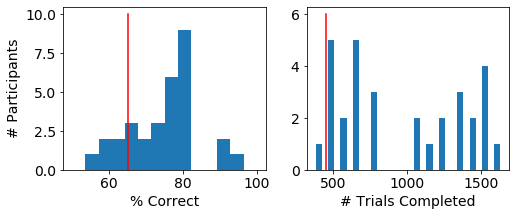

In [11]:
do_clean = True
o = np.ones(2)

acc = S_og.query('drop_trials==0').groupby('subj').correct.apply(lambda x: np.mean(x)*100).reset_index()
n_trials = S_og.groupby('subj').RT.size().reset_index()
min_trial=450 
min_acc = 0.65*100

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
perf_bns = np.linspace(50,100,15)
plt.hist(acc.correct,perf_bns)
plt.plot(min_acc*o,[0,10],'r')
plt.xlabel('% Correct')
plt.ylabel('# Participants')

plt.subplot(1,2,2)
plt.plot(min_trial*o,[0,6],'r',label='cutoff')
plt.hist(n_trials.RT,30)
plt.xlabel('# Trials Completed')
plt.show()

bad_subj = n_trials[(acc.correct.values<min_acc)|(n_trials.RT.values<min_trial)].subj
if do_clean:
    S = S_og[~np.isin(S_og.subj,bad_subj)]
else:
    S = S_og.copy()


# Get Psychophsics Curve

In [12]:
GUESS_RATE = 0.0

def softplus(x): return np.log(1 + np.exp(x))
def inv_softplus(x): return np.log(np.exp(x) - 1)

GUESS_RATE = 0.1
link_fun = softplus
def gauss_cdf(p,x):
    mu = 0
#     w=link_fun(p)
    w = link_fun(p[0])
    if len(p)>=2:
        guess_rate = p[1]
    else:
        guess_rate = GUESS_RATE 
        
    f = scipy.stats.norm(mu,w).cdf
    p_cdf = f(x)
    out = (1-guess_rate)*p_cdf + guess_rate/2
    return out

def loss_fun_meta(fun):
    def loss_fun(p,x,y):
        return log_loss(fun(p,x),y)
    return loss_fun

def log_loss(y,y_hat):
    loss = y*y_hat + (1-y_hat)*(1-y)
    return -np.sum(np.log(loss))


this_loss = loss_fun_meta(gauss_cdf)
# out = scipy.optimize.minimize(this_loss,p0,args=vals)''

In [13]:
n_bn = 8
bns_probe = np.linspace(-10,10,n_bn+1)
bns_probe_c = bns_probe[:-1] + (bns_probe[1]-bns_probe[0])/2
avg_bias_probe = np.zeros((2,n_bn))

bnds_gauss_cdf = ((0,15),(0.01,0.3))
p0 = (4,.1)
fits_gauss_cdf = np.zeros((2,len(p0)))
for ci in range(2):
    good = (~np.isnan(S.resp))&(S.compass==ci)&(S.drop_trials==0)#&(np.isin(S.subj,good_subj))
    vals = S.loc[good,['probe_offset','resp']].values.T
    for bi in range(n_bn):
        this_bin = (S.probe_offset.values>bns_probe[bi])&(S.probe_offset.values<bns_probe[bi+1])
        avg_bias_probe[ci,bi] = np.mean(S[good&this_bin].resp.values)*100
    out = scipy.optimize.minimize(this_loss,p0,args=tuple(vals),bounds=bnds_gauss_cdf)
    fits_gauss_cdf[ci] = out.x

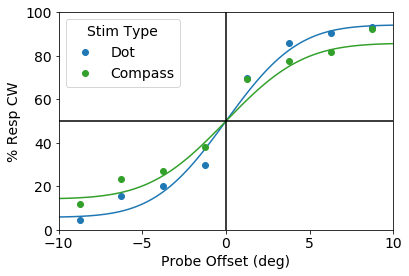

In [16]:
# plt.plot(bns_probe_c,avg_bias_probe.T,'o-')
cols = sns.color_palette('Paired',4)
bns_probe_tight = np.linspace(-10,10,100)

labs = ['Dot','Compass']
for i in range(2):
    plt.plot(bns_probe_c,avg_bias_probe[i],'o',color=cols[i*2+1],label=labs[i])
    plt.plot(bns_probe_tight,gauss_cdf(fits_gauss_cdf[i],bns_probe_tight)*100,color=cols[i*2+1])
plt.ylabel('% Resp CW')
plt.legend(title='Stim Type')
plt.xlabel('Probe Offset (deg)');
plt.plot([0,0],[0,100],'k')
plt.ylim(0,100);
xl = pm*10
plt.xlim(xl)
plt.plot(xl,[50,50],'k');
# sav_fig('v6_psychometric_curve_pooled_fit')

In [ ]:
# Save out data
# look into fitting more "complete" model including variance.
# S.to_parquet('data/data_processed_expt3_clean.parquet')